## Solving Blackjack Environment using Monte Carlo Algorithim

by Kenechi Franklin Dukor

Special thanks to Facebook-Pytorch and Udacity

#### Lets import the needed packages

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

Lets create an instance of the [blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment provided by `openai gym`

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


#### From the above result - 

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (no $=0$, yes $=1$).

The agent has two potential actions:
    - STICK = 0
    - HIT = 1

### Exploring Random Policies
Lets test the blackjack environment with some random policy.

In [4]:
for i_episodes in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        print("next state observation: ", observation)
        state = observation
        if done == True:
            print("The game has ended. Reward: ", reward)
            print("You won :) \n") if reward > 0 else print("You lost :( \n")
            break

(16, 10, False)
next state observation:  (16, 10, False)
The game has ended. Reward:  1.0
You won :) 

(21, 3, True)
next state observation:  (21, 3, True)
The game has ended. Reward:  1.0
You won :) 

(5, 5, False)
next state observation:  (5, 5, False)
The game has ended. Reward:  -1.0
You lost :( 



### Hard-coded Policy (None-Random action selection)
Now lets implement a policy that selects an action `STICK` with 80% probability when the player's current sum is greater than or equal to 18 and `HIT` when the players current sum is less than 18.

I will create a function `generate_episode_from_limit_stochastic` samples an episode using this policy.
- it will recieve the blackjack environment as input
- it will output the `state`, `action` and `rewards` for each episode i.e. This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step. In particular, episode[i] returns $(S_i, A_i, R_{i+1})$, and episode[i][0], episode[i][1], and episode[i][2] return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        prob = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=prob)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
    return episode

In [6]:
for i_episode in range(5):
    print(generate_episode_from_limit_stochastic(env))

[((10, 8, False), 0, 1.0)]
[((19, 10, False), 0, 1.0)]
[((19, 3, False), 1, -1)]
[((20, 4, False), 0, 1.0)]
[((18, 3, False), 1, -1)]


Notice that this hard coded policy doesnt really perform well.

### Short Tutorial on defaultdict
Usually, a Python dictionary throws a `KeyError` if you try to get an item with a key that is not currently in the dictionary. The `defaultdict` in contrast will simply create any items that you try to access (provided of course they do not exist yet). To create such a "default" item, it calls the function object that you pass to the constructor (more precisely, it's an arbitrary "callable" object, which includes function and type objects). For the first example, default items are created using `int()`, which will return the integer object `0`. For the second example, default items are created using `list()`, which returns a new empty list object. 

source: [Stack Overflow](https://stackoverflow.com/questions/5900578/how-does-collections-defaultdict-work)

In [7]:
# Example 1
s = 'mississippi'
d = defaultdict(int)
for k in s:
    d[k] += 1

d.items()

dict_items([('m', 1), ('i', 4), ('s', 4), ('p', 2)])

In [8]:
# Example 2
s = [('yellow', 1), ('blue', 2), ('yellow', 3), ('blue', 4), ('red', 1)]
d = defaultdict(list)
for k, v in s:
    d[k].append(v)
    
d.items()

dict_items([('yellow', [1, 3]), ('blue', [2, 4]), ('red', [1])])

### Now, lets use the Monte Carlo algorithim

I will create a function to implement the Monte Carlo Algorithim. I will implement both `first-visit` and `every-visit` MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

The function `mc_prediction` will accept four arguments

- env: This is an instance of an OpenAI Gym environment.
- num_episodes: This is the number of episodes that are generated through agent-environment interaction.
- generate_episode: This is a function that returns an episode of interaction.
- gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).

The function will output the Q-table
- Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action value corresponding to state s and action a. 

<p align="center">
  <img src="images/montecarlo_bj.png" width="700" title="hover text">

</p>

From the above, if N is the number of episodes, therefore we have 4 episodes.

This means that Q is the average of all rewards for all episodes N1 to N4. This algorithim is implemented below.

In [9]:
def mc_prediction(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Loop over the episodes
    
    for i_episode in range(1, num_episodes+1):
        # keep track of progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            # sys.stdout.flush()
        
        
        # generate an episode
        episode = generate_episode(env)
        
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode) 
        # zip separates the state, action, reward pairs in the list of tuples. 
        # Therefore, rewards contains all rewards for the episode
        
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            # calculating cummulative rewards from the current state to the last through the policy
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)]) # averaging over all episodes and visit
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]] # implementing every-visit
    return Q

In [10]:
# obtain the action-value function
Q = mc_prediction(env, 500000, generate_episode_from_limit_stochastic)

Episode 500000/500000.

Lets explore the content of `Q`

For a single episode:

- Q.items() - `dict_items([((17, 1, False), array([ 0., -1.]))])`
- Q.keys() - `dict_keys([(13, 5, False), (16, 5, False)])`
- Q.values() - `dict_values([array([ 0., -1.]), array([ 0., -1.])])`
- Q[(13, 5, False)][1] - `-1.0` *(ie Q[state][actions[i]])*

In [11]:
Q[(13, 5, False)][1]

-0.5134199134199134

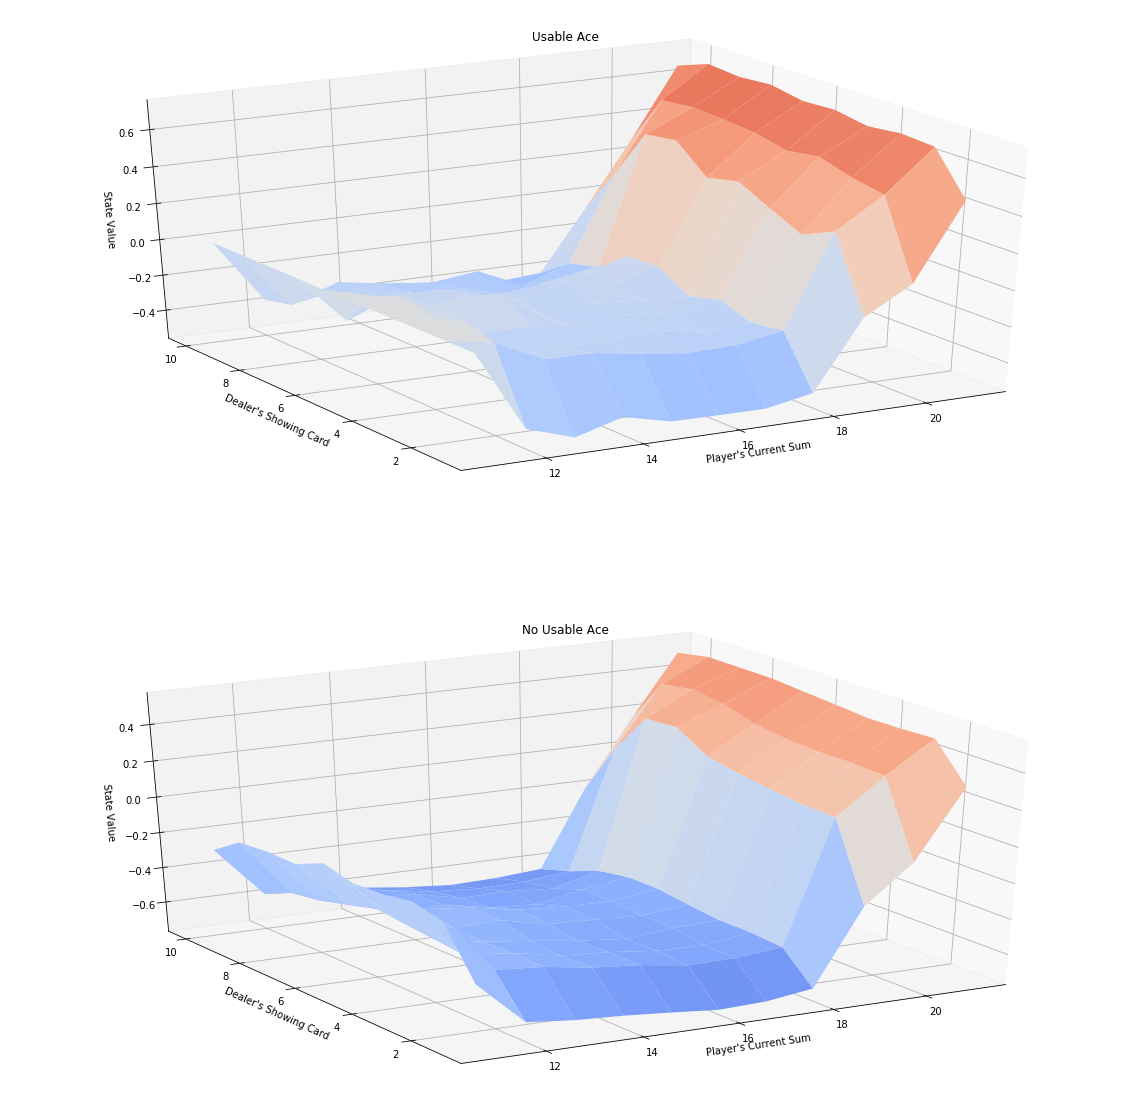

In [12]:
# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot) 

#### Test
Lets test the action-value function

In [13]:
def test_q(bj_env, Q):
    episode = []
    state = bj_env.reset()
    while True:
        # check if the state exist in memory
        if state in Q:
            print("Activated state")
            action = Q[state].argmax()
        else:
            prob = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
            action = np.random.choice(np.arange(2), p=prob)

        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            print("The game has ended. Reward: ", reward)
            print("You won :) \n") if reward > 0 else print("You lost :( \n")
            break
    return episode

In [14]:
for i_episode in range(4):
    print(test_q(env, Q))

Activated state
The game has ended. Reward:  0.0
You lost :( 

[((17, 10, False), 0, 0.0)]
Activated state
The game has ended. Reward:  1.0
You won :) 

[((14, 6, True), 0, 1.0)]
Activated state
Activated state
The game has ended. Reward:  -1.0
You lost :( 

[((6, 10, False), 1, 0), ((16, 10, False), 0, -1.0)]
Activated state
The game has ended. Reward:  1.0
You won :) 

[((21, 3, True), 0, 1.0)]


### Monte Carlo Control:

In the above, we definitely do not have the optimal policy. 

We only used a policy to populate the Q-Table. But how do we acheive this optimal policy.

We will explore below, a means of acheiving the optimal policy; This method is called the Epsilon-Greedy method.

If the agent is prsented with two actions to choose from in a state, the Greedy Method is when the agent always chooses the action that give a reward in the first trial. This will inturn limit the agent to exploriing other actions which could be better.

Therefore, we want to introduce some form of stochasticisty in the choice of the agent. i.e, allow the agent to choose the action that yields the first reward with say 90% probability, and leave the other action with 10% probability. The probability values will adjust when the agent eventually picks the second action and it yeilds a good reward.

Also, notice that instead of updating the Q-table with the average reward over all episode, we should instead update the Q-table after each episode. 

See the image below.
<p align="center">
  <img src="images/montecarlo_bj_2.png" width="700" title="hover text">

</p>

`ie` $Q_2 = (G_2 + G_1) / N_2$

But finding $Q_2$ wont be easy with code. I would be easier if we had an equation that need only tha action-value from the previous episode.

See the image below. The full derivation is in my hand-written notebook

<p align="center">
  <img src="images/montecarlo_bj_3.png" width="700" title="hover text">

</p>

The value $G - Q$ can be seen as a loss or an estimate of how good the reward $G$ is, when compared to the action-value in the $Q-table$ 

$G - Q$ is therefore referred to as $\delta$

We therefore need to take steps $\alpha$ in updating $Q$ and not taking average, such that, the latter rewards are more significant that the former.

The equation will therefore become similar to the `update-weight` equation in supervised learning.

<p align="center">
  <img src="images/montecarlo_bj_4.png" width="700" title="hover text">

</p>

The algorithim therefore becomes:

<p align="center">
  <img src="images/montecarlo_bj_5.png" width="700" title="hover text">

</p>

#### Implementation
Now, lets write an implementation of constant-$\alpha$ MC control.

The algorithm has four arguments:
- env: This is an instance of an OpenAI Gym environment.
- num_episodes: This is the number of episodes that are generated through agent-environment interaction.
- alpha: This is the step-size parameter for the update step.
- gamma: This is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).

The algorithm returns as output:
- Q: This is a dictionary (of one-dimensional arrays) where Q[s][a] is the estimated action value corresponding to state s and action a.
- policy: This is a dictionary where policy[s] returns the action that the agent chooses after observing state s.

In [15]:
def monte_carlo_control(env, num_episodes, alpha, gamma=1, eps_start=1.0, eps_limit=0.05, eps_decay=0.9997):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    epsilon = eps_start
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # we gradually decay the value of epsilon for each episode.
        epsilon = max(epsilon * eps_decay, eps_limit)
        # Generate an episode using the policy pi
        episode = generate_episode_using_epsilon_greedy(env, epsilon, nA, Q)
        
        Q = update_Q_value(episode, Q, env, alpha, gamma)
    
    # Get the policy as a dictionary which contains the state as the key, and index of the maximum reward as value
    # policy = {}
    # policy = { policy[k] = np.argmax(v) for k, v in Q.items()}
    
    # alternative
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Lets define the required function

In [16]:
def update_Q_value(episode, Q, env, alpha, gamma):
    """Update the action-value function estimate with the most recent episode"""
    # unzip the episode to separate the states, actions and rewards
    states, actions, rewards = zip(*episode)
    # prepare for discounting values
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])

    for i, s in enumerate(states):
        # we will use first-visit
        G = sum(rewards[i:]*discounts[:-(1+i)])
        Q[s][actions[i]] = Q[s][actions[i]] + (alpha * (G - Q[s][actions[i]]))
    
    return Q

def generate_episode_using_epsilon_greedy(bj_env, epsilon, nA, Q):
    '''This will return an episode based on the epsilon-greedy implementation.
       It is a modification of "generate_episode_from_limit_stochastic" function created earlier'''
    episode = []
    state = bj_env.reset()
    while True:
        if state in Q:
            action = np.random.choice(np.arange(nA), p=get_eps_prob(epsilon, nA, state, Q))
        else:
            action = env.action_space.sample()
    
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
    return episode

def get_eps_prob(epsilon, nA, state, Q):
    
    # Get previous action for that state
    prev_action = Q[state]
    # Lets divide the epsilon into two. The value will be less than 0.5
    # As epsilon decays, the result of the division will be farther away from 0.5.
    # This therefore increases the probability of picking the action with higher reward
    prob = np.ones(nA) * (epsilon / 2)
    # ie the index value is the action
    best_action = np.argmax(prev_action) 
    
    # We update the position of the best action on the prob numpy array with the corresponding probability
    # To make the sum equal 1
    prob[best_action] = (1 - epsilon) + (epsilon / 2)

#### Train
Lets train and obtain the optimal policy

In [17]:
# obtain the estimated optimal policy and action-value function
policy, Q = monte_carlo_control(env, 1000000, 0.02)

Episode 1000000/1000000.

Next, we plot the corresponding state-value function

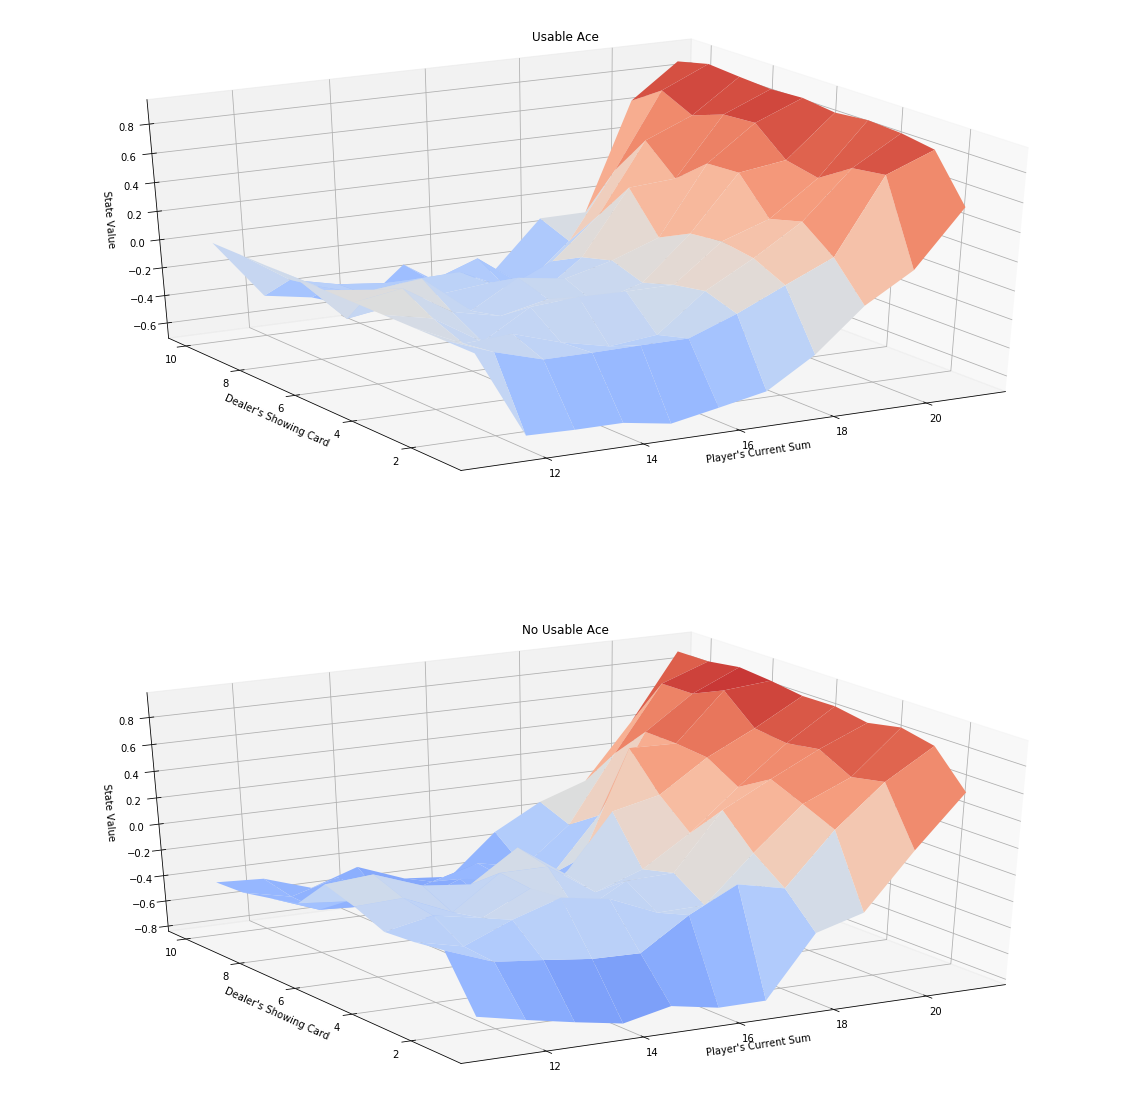

In [18]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Lets visualize the policy that is estimated to be optimal

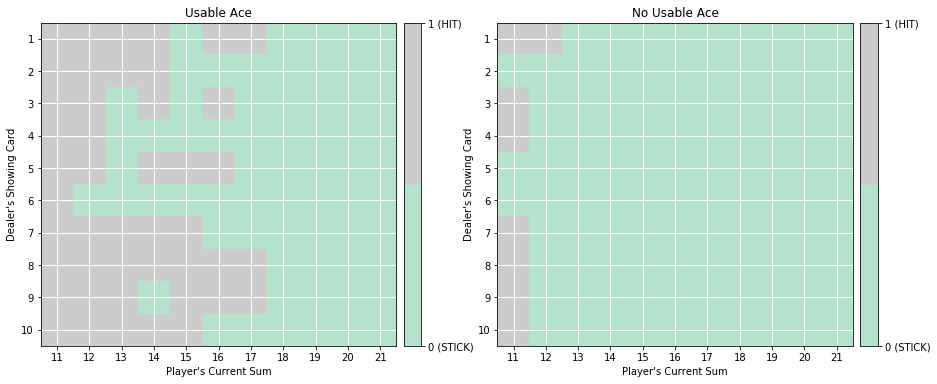

In [19]:
# plot the policy
plot_policy(policy)

#### Test
Lets test the policy

In [20]:
def test_q_optimal(bj_env, policy):
    episode = []
    state = bj_env.reset()

    while True:
        # check if the state exist in memory
        if state in policy:
            action = policy[state]
        else:
            prob = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
            action = np.random.choice(np.arange(2), p=prob)

        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
#             print("The game has ended. Reward: ", reward)
#             print("You won :) \n") if reward > 0 else print("You lost :( \n")
            break
    return reward

In [21]:
n_win = 0
n_loose = 0
for i_episode in range(1000):
    reward = test_q_optimal(env, policy)
    if reward > 0:
        n_win += 1 
    else:
        n_loose +=1
print("The agent won: ", n_win, " games")
print("The agent lost: ", n_loose, " games")

The agent won:  425  games
The agent lost:  575  games


The true optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below). Compare your final estimate to the optimal policy - how close are you able to get? If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

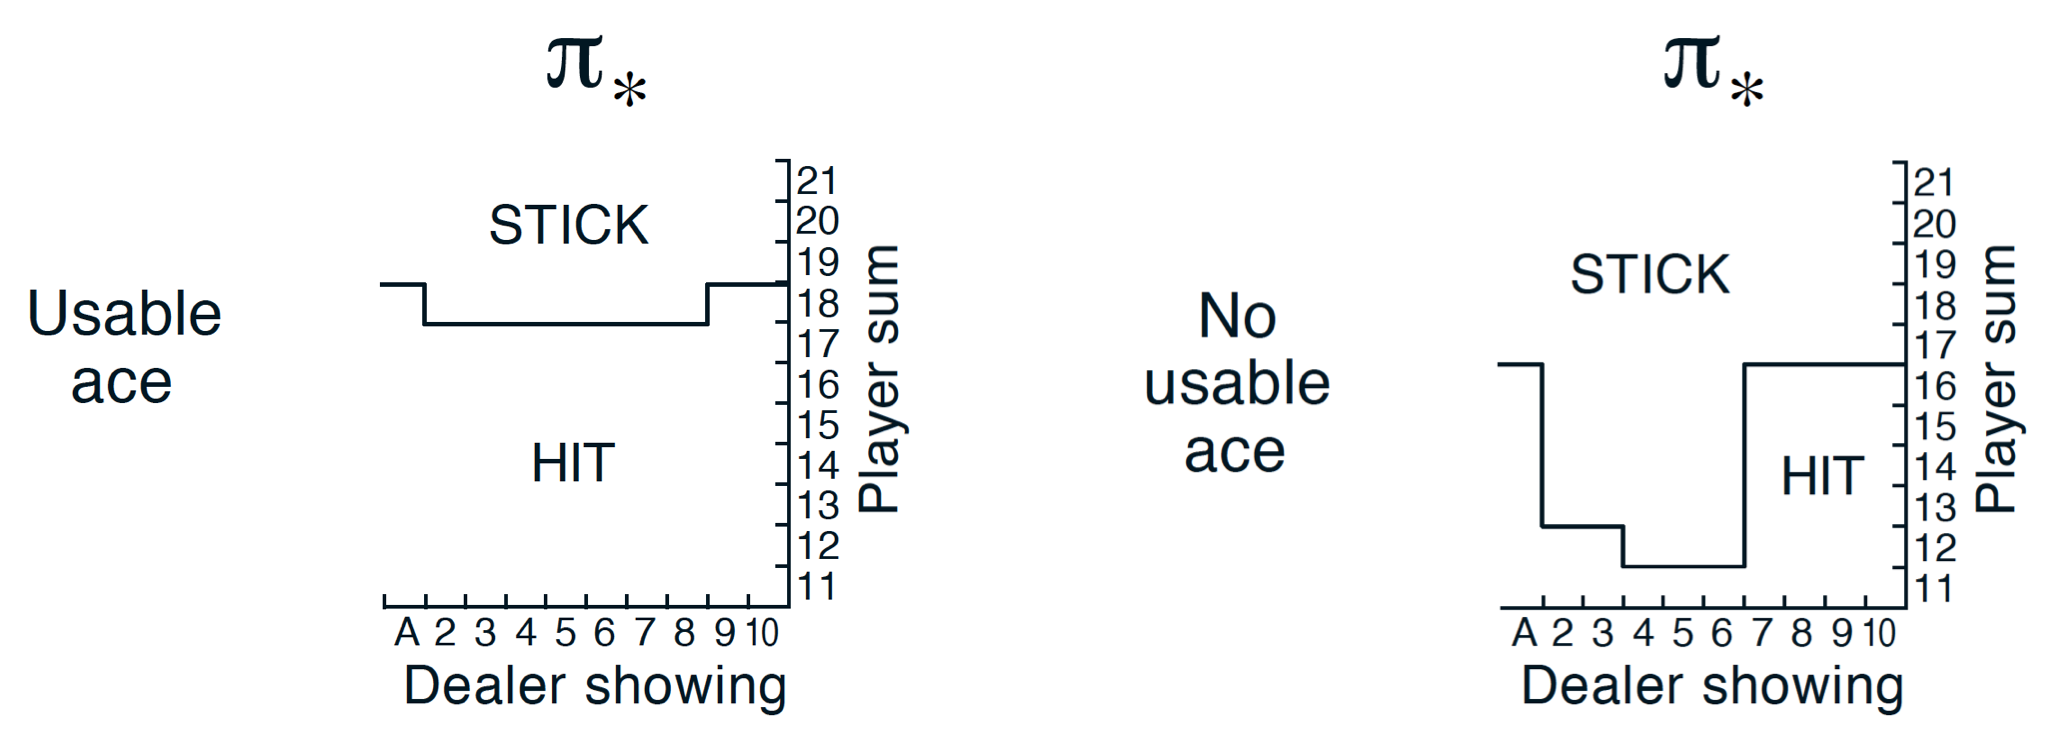